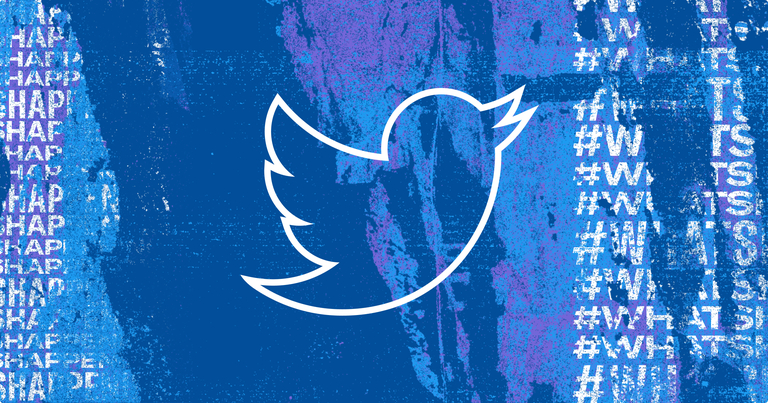

# Context
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. A machine learning model is built, that would predict which Tweets are about real disasters and which ones aren’t.

I think we all know the power of Twitter by now. It's one of the main communications channel for most of the people on earth, we get most of our daily news through our screens via twitter in these days... With the smart phones entering in our lives our newsfeed is immense but there is one problem: How'd we know if we getting real info? What if we want to seperate real situations from the non relevant data? We're lucky! We have NLP models to do heavy work for us to get distilled info. In this notebook we're going to use some basic and common NLP approaches to give us most accurate results...

# What is NLP?
Natural Language Processing refers to the branch of artificial intelligence that gives machines the ability to read, understand and derive meaning from human languages. Robots such as Sophia or home assistants uses Natural Language Processing (NLP) to sound like human and 'understand' what you're saying. NLP can be represented by using the Venn diagram as below.

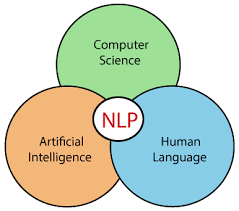

## Let's get Started !!..

# Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

# Training Data

In [ ]:
Train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
Train.head()

In [ ]:
print('Rows and columns in training dataset : ',Train.shape)

In [ ]:
Train.info()

# Exploratory Data Analysis

## Target Variable Distribution

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,6))
colors = ['#87ace8','#e3784d']

ax = sns.countplot(x='target',data=Train, palette=colors)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frequency of distribution of Tweets',fontsize=15)
plt.show()

fig = px.pie(Train, names='target', height=600, width= 600, color_discrete_sequence=colors, title='Pie Chart for distribution of Tweets')
fig.update_traces(textfont_size=15)
fig.show()

#### Note:
- The data doesn't seems to be biased as there is fair distribution of disaster/non-disaster tweets data is given.

### Keywords in Training dataset

In [ ]:
dist_keyword=Train['keyword'].value_counts()
dist_keyword

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,10))

top_keywords=Train['keyword'].value_counts()[:20]
ax = sns.barplot(y=top_keywords.index,x=top_keywords,palette='rocket',data=Train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 20 Keywords in tweets',fontsize=15)
plt.xticks(rotation=45)
plt.show()

## Plotting Top 20 Disaster and Non-Disaster keywords

In [ ]:
disaster_keywords = Train.loc[Train["target"] == 1]["keyword"].value_counts()
non_disaster_keywords = Train.loc[Train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax1 = sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Greens_r")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Disaster Tweets : Top 20 Keywords",fontsize=15)
ax[0].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=non_disaster_keywords[0:20].index, x= non_disaster_keywords[0:20], orient='h', ax=ax[1], palette="Purples_r")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Non-Disaster Tweets : Top 20 Keywords",fontsize=15)
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

## Tweets Length

In [ ]:
Train['length']  = Train["text"].apply(len)
Train['length']

In [ ]:
print('Tweet chraracter length for:',Train['text'][0],'is',Train['length'][0])

In [ ]:
plt.figure(figsize=(10,6))

sns.histplot(Train['length'], kde=True,color='orange',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

## Tweet length of Disaster/Non-disaster tweets

In [ ]:
Train.hist(column='length', by = 'target', bins =40, figsize= (20,6))
plt.show()

## Top Locations Tweets sent from.

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,10))

locations = Train["location"].value_counts()
ax = sns.barplot(y=locations[0:20].index,x=locations[0:20],palette='hls',data=Train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 20 locations tweets sent from',fontsize=15)
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

## Handling Null Values

In [ ]:
Train.isna().sum()

In [ ]:
Train=Train.drop(['location'],axis=1)
Train = Train.dropna()

In [ ]:
Train.isna().sum().sum()

In [ ]:
Train.head()

In [ ]:
Train.reset_index(inplace=True)    # Here we are reseting our index

In [ ]:
Train.head()

In [ ]:
x=Train['text']
# here we are making independent features
y=Train['target']
y.shape

### Importing necessary libraries for Data-preprocessing

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#### Note:
- Here we are importing **nltk**,**stopwords** and **PorterStemmer** we are using stemming on the text 
- We have and stopwords will help in removing the stopwords in the text
- **re** is **regular expressions** used for identifying only words in the text and ignoring anything else

In [ ]:
nltk.download('stopwords')

📌 **Important Consideration :**

- re.sub()
    - Replace with regular expression 
    - Replace multiple substrings with the same string
    - Replace using the matched part
    - Get the count of replaced parts
    - Here we are going to replace all regural expression which are not between a to z or A to Z with whitespace.

- result.lower:
    - By this we are going to replace all the words in Lower case,So that all are treated as equally

- ps.stem()
    - Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers.
    - A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”

In [ ]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(Train)):
    review = re.sub('[^a-zA-Z]', ' ', Train['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
corpus[:10]

In [ ]:
wordcloud = WordCloud(background_color="white", 
                      max_words=200,
                      width=1500, 
                      height=800, colormap='Paired').generate(" ".join(corpus))

plt.figure(figsize=(32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### One Hot representation
- Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix.

In [ ]:
voc_size=5000

one_hot_rep=[one_hot(words,voc_size)for words in corpus] 
one_hot_rep[:5]

In [ ]:
corpus[0]

In [ ]:
one_hot_rep[0]

In [ ]:
len(one_hot_rep[0])

### Embedding Representation
- **Pad_Sequences**
    - The pad_sequences() function in the Keras deep learning library can be used to pad variable length sequences. The default padding value is 0.0, which is suitable for most applications, although this can be changed by specifying the preferred value via the “value” argument.
    - By this we are going to make all the sentances in same length.There are 2 types of Padding "Pre" and "Post",pre means it's going to add 0 in front and post means it's goint add 0 in back

In [ ]:
sentence_length=25    # here we are specifying a sentence length so that every sentence in the corpus will be of same length

embedded_docs = pad_sequences(one_hot_rep,padding='pre',maxlen=sentence_length)
print(embedded_docs)

## Importing necessary Libraries for LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

# Modeling

In [ ]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sentence_length))
model.add(Dropout(0.3))
model.add(LSTM(200))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
z = np.array(embedded_docs)
y = np.array(y)

z.shape, y.shape

### Splitting the Training dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.33, random_state=42)

### Training the Model

In [ ]:
res = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64)

In [ ]:
def plot_learning_curve(history,epochs):
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc ="upper left")
    plt.show()
    
plot_learning_curve(res,20)

#### Note:
- So We should train our model by 2 epochs. Because at 2 epochs we are getting a Perfect model with perfect accuracy for both train & validation

## Importing Test Data

In [ ]:
Test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv') 
Test.head()

In [ ]:
print('Rows and columns in test dataset : ',Test.shape)

In [ ]:
Test_id = Test['id']  
Test=Test.drop(['id','keyword','location'],axis=1)    #Dropping unnecessary columns
Test.head()

### Checking Null Values

In [ ]:
Test.isnull().sum()

### Data preprocessing Test data

In [ ]:
ps = PorterStemmer()
corpus_test = []
for i in range(0, len(Test)):
    review = re.sub('[^a-zA-Z]', ' ',Test['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [ ]:
corpus_test[:5]

### One hot representation for the Test Data corpus

In [ ]:
one_hot_rep_Test=[one_hot(words,voc_size)for words in corpus_test] 

### Embedding Representation

In [ ]:
sentence_length=25

embedded_docs_test=pad_sequences(one_hot_rep_Test,padding='pre',maxlen=sentence_length)
print(embedded_docs_test)

In [ ]:
x_test=np.array(embedded_docs_test)
x_test

### Making predictions for the test dataset

In [ ]:
check=model.predict(x_test)
check = check.round()

In [ ]:
val=[]
for i in check:
    val.append(i[0])
    
submission = pd.DataFrame({'id':Test_id, 'label':val})
submission.head()

### <p style="text-align:center;"><span style="color:red">💬 Thanks for reading till the end!! If you liked the notebook till here then please do Upvote👍 and I am all ears to advice/remarks if you think anything needs to be added/modified.!!😃</span></p>
<h1 style="padding:8px;background-color:lightblue;margin:0;color:white;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 50px;overflow:hidden;font-weight:500">Work in Progress for Notebook betterment !!</h1>